# Freedman's paradox

In this notebook, we study Freedman's paradox. It is a simple paradox, where we perfrom adaptive feature selection. At each step of the procedure, we are selecting "better" features, but end up having a worse model. 

This is one of the reasons why feature selection, and any other "data cleaning" procedure might lead to biased results. The problem already appears when we want to fit independent features to a given dependent feature. However, it is much worse when we simply want to discover relationships between features. To see this, note that feature selection for a linear regression problem amounts to answering the question 'which of the n input features are related to the 1 output feature?'. So we need to test $O(n)$ relationships. In the more general setting, we are asking 'which features are related to which other features?'. There we have $O(n^2)$ opportunities to make a mistake!

Let us walk through this example.


In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# This example makes sense only when the number of featues is of the same order as the number of data points.
n_features = 100
n_data = 2 * n_features

In [3]:
# Here everything is normally distributed, with none of the features predictive of y
X = np.random.normal(size=[n_data, n_features])
y = np.random.normal(size=n_data)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Regression on the standard featues

The function *f_regression* returns a vector of F-statistics and p-values. If the null hypothesis assumption is true (which it is), then the p-values should have a uniform distribution in [0,1]. We can confirm this by doing the following plot.

Nevertheless, this means that approximately 10% of the features will have a p-value <0.1. We must not forget that this will happen even in perfect conditions. That is how p-values are by construction.

(array([12.,  6.,  9.,  7., 13., 11., 11., 11.,  9., 11.]),
 array([0.00672271, 0.10545089, 0.20417906, 0.30290724, 0.40163541,
        0.50036359, 0.59909176, 0.69781993, 0.79654811, 0.89527628,
        0.99400446]),
 <BarContainer object of 10 artists>)

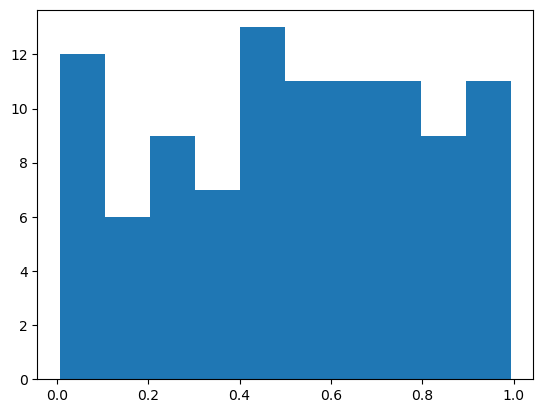

In [11]:
from sklearn.feature_selection import f_regression
[F, p] = f_regression(X_train, y_train)
plt.hist(p)

(array([68., 11.,  6.,  6.,  4.,  3.,  0.,  1.,  0.,  1.]),
 array([5.66568213e-05, 7.55746878e-01, 1.51143710e+00, 2.26712732e+00,
        3.02281754e+00, 3.77850776e+00, 4.53419798e+00, 5.28988821e+00,
        6.04557843e+00, 6.80126865e+00, 7.55695887e+00]),
 <BarContainer object of 10 artists>)

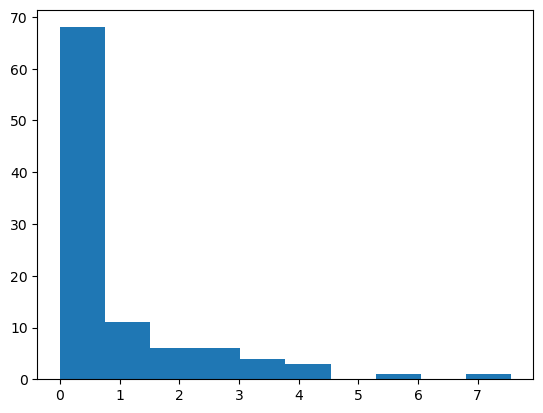

In [20]:
# For completeness, we can also plot the histogram of F-statistics.
plt.hist(F)


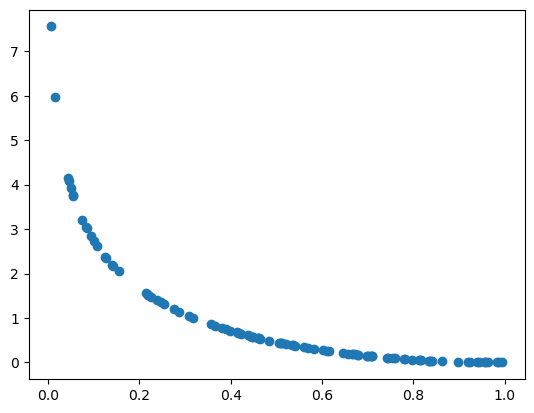

In [19]:
# Here is how the p-values relate to the F-statistic
# all F-values smaller than some threshold correspond to a corresponding small p-value.
plt.plot(p, F, 'o')

# Doing feature selection and refitting

We saw that if we choose features with a p-value < 0.1, we are randomly selecting 10% of the features, even if they have no relevance for the task.

What will happen if we first select features and then refit a linear regressor? Would it still be the same, would it be better, or worse?


In [35]:
# Fit the data and then transform the features
from sklearn.feature_selection import SelectKBest
X_2 = SelectKBest(f_regression, k=2).fit_transform(X_train, y_train)
X_5 = SelectKBest(f_regression, k=5).fit_transform(X_train, y_train)
X_10 = SelectKBest(f_regression, k=10).fit_transform(X_train, y_train)
X_20 = SelectKBest(f_regression, k=10).fit_transform(X_train, y_train)

(array([1., 1., 0., 0., 2., 1., 2., 0., 1., 2.]),
 array([0.00672271, 0.01450998, 0.02229724, 0.03008451, 0.03787178,
        0.04565904, 0.05344631, 0.06123358, 0.06902084, 0.07680811,
        0.08459538]),
 <BarContainer object of 10 artists>)

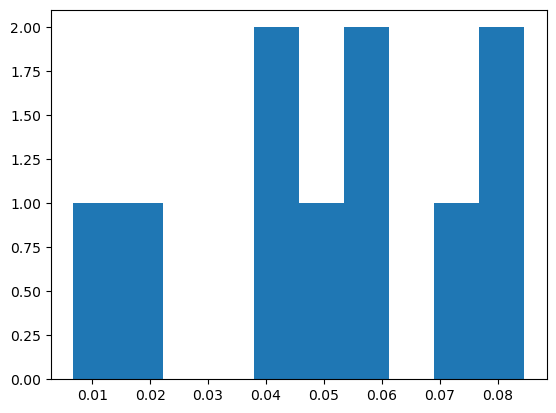

In [36]:
[F, p] = f_regression(X_10, y_train)
plt.hist(p)

(array([1., 1., 0., 0., 2., 1., 2., 0., 1., 2.]),
 array([0.00672271, 0.01450998, 0.02229724, 0.03008451, 0.03787178,
        0.04565904, 0.05344631, 0.06123358, 0.06902084, 0.07680811,
        0.08459538]),
 <BarContainer object of 10 artists>)

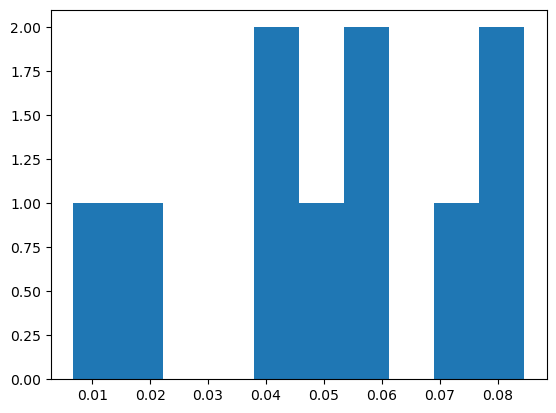

In [37]:
[F, p] = f_regression(X_20, y_train)
plt.hist(p)